# Intro

In this project, we have been tasked with creating a model that correctly classifies whether a patient has pneumonia or not. We will use neural networks to classify the xray image of patient's lung to determine the patient's diagnosis.

First, we will load the full dataset from Kaggle of the pneumonia images. Then we will preview some of the images and explore the distribution of classes. Then, we will iterate through a number of neural network models including convolutiona neural network models and choose the model that performs best on our test set as our final model.

Before we get started, I want to note that we did not use the original split of data from Kaggle. We believed the validation set of images was too small (only 26 images) and in practice should have more data than the test set. Therefore, we moved 300 images from the test set (150 pneumonia and 150 normal) into the validation set in our folders. I have included this split in the repository for replication.

# Obtain

In [1]:
# import necessary libraries
# ! pip install tensorflow
# ! pip install keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from keras import layers
from keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

##  Load Image Data off the Local Disk

In [3]:
# use os module to obtain file paths to the images
main_directory = os.listdir('/Users/saman/x_ray_images/')
print(main_directory)

['test', 'train', 'val']


In [4]:
data_dir = '/Users/saman/x_ray_images/'
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")
val_dir = os.path.join(data_dir, "val/")

In [5]:
# separate normal and pneumonia images

# train folder data
os.listdir(train_dir)
train_normal = train_dir + 'NORMAL/'
train_pneumo = train_dir + 'PNEUMONIA/'

# test folder data
os.listdir(test_dir)
test_normal = test_dir + 'NORMAL/'
test_pneumo = test_dir + 'PNEUMONIA/'

# val folder data
os.listdir(val_dir)
val_normal = val_dir + 'NORMAL/'
val_pneumo = val_dir + 'PNEUMONIA/'

In [6]:
# preview number of images in each category

print(f'There are {len(os.listdir(train_normal))} images in train normal.' )
print(f'There are {len(os.listdir(train_pneumo))} images in train pneumonia.' )
print(f'There are {len(os.listdir(train_pneumo))+len(os.listdir(train_normal))} total images in the train set.' )
print('\n')
print(f'There are {len(os.listdir(test_normal))} images in test normal.' )
print(f'There are {len(os.listdir(test_pneumo))} images in test pneumonia.' )
print(f'There are {len(os.listdir(test_pneumo))+len(os.listdir(test_normal))} total images in the test set.' )
print('\n')
print(f'There are {len(os.listdir(val_normal))} images in validation normal.' )
print(f'There are {len(os.listdir(val_pneumo))} images in validation pneumonia.' )
print(f'There are {len(os.listdir(val_pneumo))+len(os.listdir(val_normal))} total images in the validation set.' )

There are 1341 images in train normal.
There are 3875 images in train pneumonia.
There are 5216 total images in the train set.


There are 84 images in test normal.
There are 240 images in test pneumonia.
There are 324 total images in the test set.


There are 158 images in validation normal.
There are 158 images in validation pneumonia.
There are 316 total images in the validation set.


## Generate Image Data

Use the ImageDataGenerator to generate tensor image data in batches. Use the flow_from_directory method to take the path from the data folder to generate the batches of training, test and validation data. Since we need to reshape the image matrices before they are fed into the MLP model, we are going to take the entire data sample as our batch size in these generators. We will also reshape all of the images so that they are 150 x 150 pixels, and rescale the matrix values so that the values are on a scale of 0-1.

In [7]:
train_len = len(os.listdir(train_pneumo))+len(os.listdir(train_normal))
test_len = len(os.listdir(test_pneumo))+len(os.listdir(test_normal))
val_len = len(os.listdir(val_pneumo))+len(os.listdir(val_normal))

In [8]:
# set up parameters for data generators
# normalize RGB matrix values to be on 0-1 scale
rescale = 1./255
# reshape images to be 150 pixels x 150 pixels
target_size = 150,150
# batch_size = 32
# need binary labels; 0 for normal, 1 for pneumonia
class_mode = 'binary'

In [9]:
train_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(train_dir,
                                                         target_size=(target_size),
                                                         batch_size=train_len,
                                                         class_mode=class_mode)

Found 5216 images belonging to 2 classes.


In [10]:
test_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(test_dir,
                                                         target_size=(target_size),
                                                         batch_size=test_len,
                                                         class_mode=class_mode)

Found 324 images belonging to 2 classes.


In [11]:
val_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(val_dir,
                                                         target_size=(target_size),
                                                         batch_size=val_len,
                                                         class_mode=class_mode)

Found 316 images belonging to 2 classes.


In [12]:
# Use next function to store a full batch of image and label data
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [13]:
m_train = train_images.shape[0]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 324
Number of validation samples: 316
train_images shape: (5216, 150, 150, 3)
train_labels shape: (5216,)
test_images shape: (324, 150, 150, 3)
test_labels shape: (324,)
val_images shape: (316, 150, 150, 3)
val_labels shape: (316,)


# Data Cleaning

## Previewing Images

In [14]:
# preview what binary labels belong to which image classification
class_dict = train_generator.class_indices 
class_dict

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
# function that returns the correct label name based on binary label
def return_key(val):
    for key, value in class_dict.items():
        if value==val:
            return key
    return('Key Not Found')

In [118]:
# function that returns image with the correct label

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(images_arr, axes)):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(return_key(train_labels[i]))
    plt.tight_layout()
    plt.show()

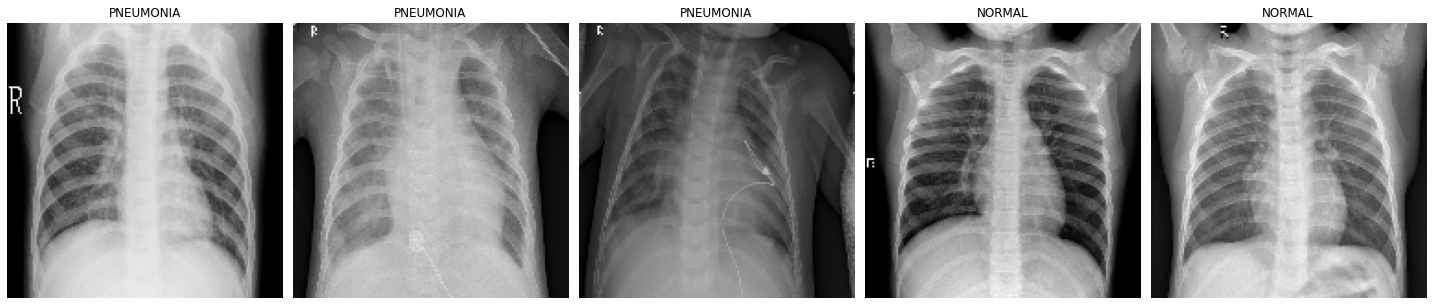

In [119]:
plotImages(train_images[:5])

In [116]:
train_labels[:5]

array([1., 1., 1., 0., 0.], dtype=float32)

According to our class indices, a value of 1 means the image is of pneumonia and 0 means the image is normal.

Now, reshape each images matrix so it can be fed into the neural networks. The expected input shape is m x n, where n is the total number of elements in the feature vector for each image, or the number of rows after unrowing the 3 RBG 64x64 matrices.

In [24]:
train_images.shape

(5216, 150, 150, 3)

This matrix is in the format of (batch_size, pixel height, pixel width, 3 RBG matrices)

In [25]:
train_images_final = train_images.reshape(m_train,-1)
test_images_final = test_images.reshape(m_test,-1)
val_images_final = val_images.reshape(m_val,-1)

print(np.shape(train_images_final))
print(np.shape(test_images_final))
print(np.shape(val_images_final))

(5216, 67500)
(324, 67500)
(316, 67500)


Now our matrices are ready for input in the neural network.

## Explore Class Imbalance

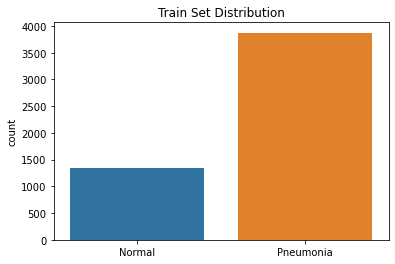

In [122]:
# need to set column names
ax = sns.countplot(x=pd.Series(train_labels))
ax.set_title('Train Set Distribution')
ax.set_xticklabels(['Normal', 'Pneumonia']);

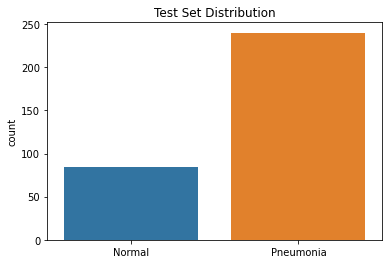

In [123]:
ax = sns.countplot(x=pd.Series(test_labels))
ax.set_title('Test Set Distribution')
ax.set_xticklabels(['Normal', 'Pneumonia']);

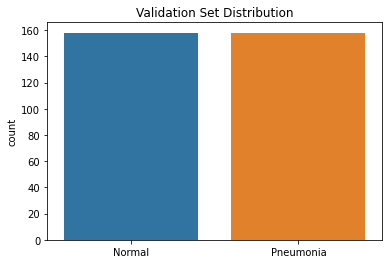

In [125]:
ax = sns.countplot(x=pd.Series(val_labels))
ax.set_title('Validation Set Distribution')
ax.set_xticklabels(['Normal', 'Pneumonia']);

# Modeling

## Model 1: MLP

We are going to begin our modeling with a fully connected dense neural network, or a multi-level perceptron. See below for our initial parameters we are using in the model.

**Optimizer**: for our optimizer, which is the method used to minimize our cost function and update the weights of our model, we are using Stochastic Gradient Descent (SGD). With a batch size of 32, this is the number of samples used before calculating our loss and updating our weights (backward propagation). We are also going to use a decaying learning rate. Learning rates control by what factor weights are updated during backpropagation. Decaying learning rates use a larger learning rate to begin with, as we assume we are farther from the point of optimization. As we get closer to optimization, the learning rate decreases, which makes it less likely for us to overshoot our global minimum. We used an Exponential Decaying rate in this case.

**Loss Function**: The loss function we are trying to minimize in our model is Binary Cross-entropy, which is used when there are only two label classes (0 and 1) and computes the cross entropy loss between the true and predicted labels.

**Metrics**: we will use accuracy as the main performance metric tracked in all of our models, which is simply how frequently predictions equal labels.

**Activation Function**: The activation function is a function the output in each layer must go through before passing to the next layer. In our models, we will use Rectified Linear Unit (ReLu) as the activation function in all hidden layers and a sigmoid function as the activation function for our output layer.

**Batch Size**: Batch size is the number of training examples used in one forward and backward propagation. We will use the default batch size of 32, as this has been proven to work well in many cases. Smaller batch sizes can be noisier but can decrease overall overfitting.

**Epochs**: An epoch is a unit of one forward and backward propagation of all training examples. We will use 30 epochs in our models in the interest of time. We can run models with especially storng performance for 50-100 epochs and check those results. 

TO DELETE
Some Terminology:

1 epoch = one forward propagation and one backward propagation of all training examples.
batch size= number of training examples in one forward/backwatd pass. Higher batch size=more memory
number of iterations = number of passes using batch size number of examples.
With 1000 training examples and batch size of 500, will take 2 iterations to complete 1 epoch.

Smaller batch sizes are noisier, meaning this can have a regularizing effect on the data and decrease overfitting.

Here we are using mini-batch gradient descent, where our batch size is greater than 1 and less than the size of our training set.

We are using Stochastic Gradient Descent (SGD) as our optimizer.  are also setting our learning rate for gradient descent equal to 0.001, to make sure our model converges and we don't miss the global minimum.

We are going to use Adaptive Moment Estimation as our optimizer (Adam), which tends to outperform other optimizers. Adam has a default learning rate of 0.001.

We are going to use binary crossentropy as our loss function since this is a binary classification problem.

We will use accuracy as the evaluation metric we are tracking.

We will use Rectified Linear Unit (ReLu) for the activation function for our hidden layersm as it allows the network to converge quickly.

In [30]:
# set learning rate schedule using Exponential Decay
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    # start with .01 lr
    initial_learning_rate=.01,
    # decay by 0.9 ^(step/decay_steps)
    decay_steps=10000,
    decay_rate=0.9)

In [31]:
from keras.optimizers import SGD, Adam, RMSprop
#opt = 'Adam'
opt = SGD(learning_rate=lr_schedule)
loss = 'binary_crossentropy'
metrics = ['accuracy']

To start with, we are going to run a baseline, fully connected model. This model will have limited layers and limited units.

In [126]:
input_shape

67500

In [36]:
# baseline fully connected model
input_shape = train_images_final.shape[1]

np.random.seed(123)

# initialize model
model_1 = Sequential()

# add 1 hidden dense layer to the network with 10 units to start
model_1.add(layers.Dense(10, activation='relu', input_shape=(input_shape,)))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [37]:
# Compile model, specify optimizer, loss function and metric
model_1.compile(optimizer=opt,
              loss= loss,
              metrics=metrics)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                675010    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 675,021
Trainable params: 675,021
Non-trainable params: 0
_________________________________________________________________


**Model Summary**: The model summary tells us how many parameters are in our model, in this case 675,021. For the first layer, this is calculated as 67500 weight inputs x 10 nodes, plus 10 bias terms. For the second layer, there are 10 weights resulting from the first layer plus 1 bias term, resulting in 11 parameters. This leads to a total of 675,021 parameters. As a neural network becomes more complicated, the number of parameters will increase.

In [38]:
#fit model
history_1 = model_1.fit(train_images_final,
                        train_labels,
                        batch_size=32,
                        epochs=30,
                        validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 4s 22ms/step - loss: 0.6624 - accuracy: 0.7306 - val_loss: 0.8001 - val_accuracy: 0.5348
Epoch 2/30
163/163 [==============================] - 2s 12ms/step - loss: 0.3736 - accuracy: 0.8569 - val_loss: 0.9521 - val_accuracy: 0.5759
Epoch 3/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2991 - accuracy: 0.8969 - val_loss: 1.1849 - val_accuracy: 0.5665
Epoch 4/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2592 - accuracy: 0.9237 - val_loss: 0.7543 - val_accuracy: 0.7025
Epoch 5/30
163/163 [==============================] - 2s 11ms/step - loss: 0.2529 - accuracy: 0.9209 - val_loss: 0.8094 - val_accuracy: 0.6930
Epoch 6/30
163/163 [==============================] - 2s 12ms/step - loss: 0.2258 - accuracy: 0.9387 - val_loss: 0.6375 - val_accuracy: 0.7342
Epoch 7/30
163/163 [==============================] - 2s 13ms/step - loss: 0.2199 - accuracy: 0.9355 - val_loss: 0.6039 - val_accuracy: 0.7532

In [39]:
# create function for visualizing training results
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

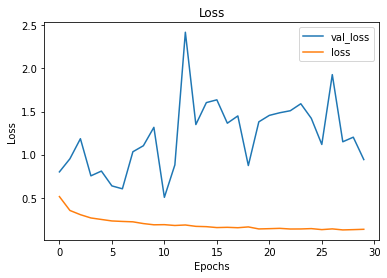

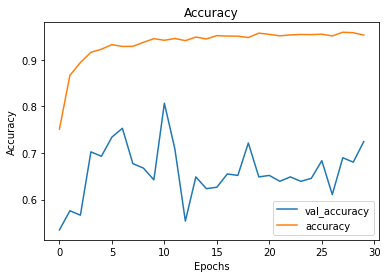

In [40]:
visualize_training_results(history_1)

In [133]:
# create model results function to return
def model_results(model):
    train_loss, train_acc = model.evaluate(train_images_final, train_labels, batch_size=32)
    val_loss, val_acc = model.evaluate(val_images_final, val_labels, batch_size=32)
    test_loss, test_acc = model.evaluate(test_images_final, test_labels, batch_size=32)
    print(f"training loss:{round(train_loss,2)}, training accuracy:{round(train_acc,2)}")
    
    print(f"validation loss:{round(val_loss,2)}, validation accuracy:{round(val_acc,2)}")
    
    print(f"testing loss:{round(test_loss,2)}, testing accuracy:{round(test_acc,2)}")

In [134]:
model_results(model_1)

11/11 [==============================] - 0s 7ms/step - loss: 0.4630 - accuracy: 0.8519
training loss:0.12, training accuracy:0.96
validation loss:0.94, validation accuracy:0.72
testing loss:0.46, testing accuracy:0.85


In [41]:
model_1.evaluate(train_images_final, train_labels)

163/163 [==============================] - 1s 7ms/step - loss: 0.1237 - accuracy: 0.9594


[0.12367846816778183, 0.9593558311462402]

In [42]:
model_1.evaluate(val_images_final, val_labels)

10/10 [==============================] - 0s 5ms/step - loss: 0.9430 - accuracy: 0.7247


[0.9429740309715271, 0.7246835231781006]

In [ ]:
model

This model has high performance on the training data, but it does not appear to be converging on the validation set. Although we will definitely need to handle some of the overfitting in this model, let's  tune the number of layers and units in our model and see how it changes our results.

## Model 2: Determine Number of Layers

In [43]:
np.random.seed(123)

# initialize model
model_2 = Sequential()
# add Dense layers to the network
model_2.add(layers.Dense(10, activation='relu', input_shape=(input_shape,)))
# add two additional hidden layers to our network
model_2.add(layers.Dense(7, activation='relu'))
model_2.add(layers.Dense(5, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [44]:
# Compile model, specify loss function
model_2.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_2 = model_2.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 3s 14ms/step - loss: 0.6751 - accuracy: 0.6950 - val_loss: 0.7054 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 2s 12ms/step - loss: 0.6170 - accuracy: 0.7516 - val_loss: 0.7272 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 2s 12ms/step - loss: 0.5996 - accuracy: 0.7352 - val_loss: 0.7490 - val_accuracy: 0.5000
Epoch 4/30
163/163 [==============================] - 2s 12ms/step - loss: 0.5860 - accuracy: 0.7386 - val_loss: 0.7674 - val_accuracy: 0.5000
Epoch 5/30
163/163 [==============================] - 2s 12ms/step - loss: 0.5728 - accuracy: 0.7478 - val_loss: 0.7817 - val_accuracy: 0.5000
Epoch 6/30
163/163 [==============================] - 2s 12ms/step - loss: 0.5826 - accuracy: 0.7326 - val_loss: 0.7933 - val_accuracy: 0.5000
Epoch 7/30
163/163 [==============================] - 2s 12ms/step - loss: 0.5779 - accuracy: 0.7364 - val_loss: 0.8019 - val_accuracy: 0.5000

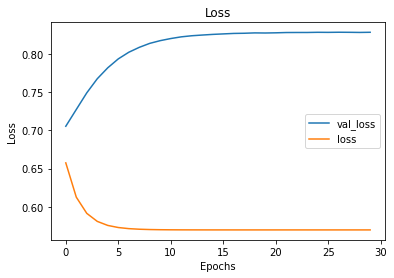

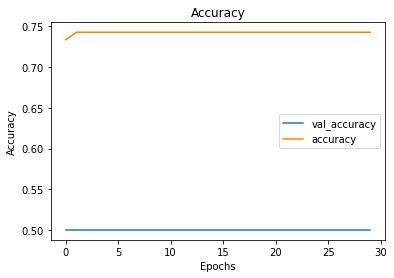

In [45]:
visualize_training_results(history_2)

In [135]:
model_results(model_2)

11/11 [==============================] - 0s 8ms/step - loss: 0.5723 - accuracy: 0.7407
training loss:0.57, training accuracy:0.74
validation loss:0.83, validation accuracy:0.5
testing loss:0.57, testing accuracy:0.74


In [46]:
model_2.evaluate(train_images_final, train_labels)

163/163 [==============================] - 1s 7ms/step - loss: 0.5700 - accuracy: 0.7429


[0.5699955224990845, 0.7429064512252808]

In [47]:
model_2.evaluate(val_images_final, val_labels)

10/10 [==============================] - 0s 5ms/step - loss: 0.8280 - accuracy: 0.5000


[0.8280272483825684, 0.5]

Our accuracy scores for both training and validation got worse. Let's see if changing the number of units would improve our scores at all.

## Model 3: Determine Number of Units

In [48]:
np.random.seed(123)

# initialize model
model_3 = Sequential()
# add Dense layers to the network
model_3.add(layers.Dense(20, activation='relu', input_shape=(input_shape,)))
# add additional layer
model_3.add(layers.Dense(10, activation='relu'))
model_3.add(layers.Dense(7, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [49]:
model_3.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_3 = model_3.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 3s 17ms/step - loss: 0.5634 - accuracy: 0.7348 - val_loss: 0.6544 - val_accuracy: 0.5127
Epoch 2/30
163/163 [==============================] - 2s 14ms/step - loss: 0.3956 - accuracy: 0.7968 - val_loss: 0.7033 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 2s 14ms/step - loss: 0.3075 - accuracy: 0.8696 - val_loss: 0.5647 - val_accuracy: 0.7785
Epoch 4/30
163/163 [==============================] - 2s 14ms/step - loss: 0.3110 - accuracy: 0.8821 - val_loss: 1.1351 - val_accuracy: 0.6013
Epoch 5/30
163/163 [==============================] - 2s 14ms/step - loss: 0.2146 - accuracy: 0.9203 - val_loss: 0.7500 - val_accuracy: 0.6930
Epoch 6/30
163/163 [==============================] - 2s 15ms/step - loss: 0.1763 - accuracy: 0.9286 - val_loss: 0.6409 - val_accuracy: 0.6962
Epoch 7/30
163/163 [==============================] - 2s 15ms/step - loss: 0.1564 - accuracy: 0.9362 - val_loss: 1.0120 - val_accuracy: 0.6519

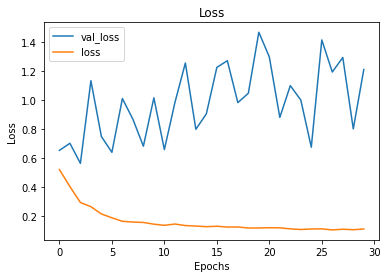

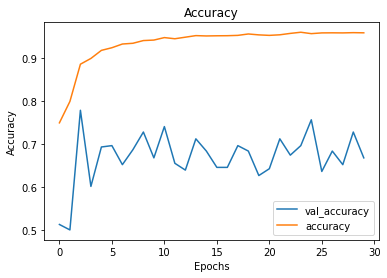

In [50]:
visualize_training_results(history_3)

In [136]:
model_results(model_3)

11/11 [==============================] - 0s 7ms/step - loss: 0.6342 - accuracy: 0.8210
training loss:0.09, training accuracy:0.97
validation loss:1.21, validation accuracy:0.67
testing loss:0.63, testing accuracy:0.82


In [51]:
model_3.evaluate(train_images_final, train_labels)

163/163 [==============================] - 2s 8ms/step - loss: 0.0886 - accuracy: 0.9670


[0.08863631635904312, 0.967024564743042]

In [52]:
model_3.evaluate(val_images_final, val_labels)

10/10 [==============================] - 0s 6ms/step - loss: 1.2124 - accuracy: 0.6677


[1.2124392986297607, 0.6677215099334717]

Although our training accuracy increased, our validation accuracy is significantly lower, showing this model has clearly overfit to the training data. Let's see if applying different strategies of regularization can improve our results.

## Model 4: Early Stopping

Early stopping is a regularization method that works by stopping model training once the model performance stops improving on a hold out validation set.

In [138]:
np.random.seed(123)

# initialize model
model_4 = Sequential()
# add Dense layers to the network
model_4.add(layers.Dense(10, activation='relu', input_shape=(input_shape,)))
# add additional layer
model_4.add(layers.Dense(7, activation='relu'))
model_4.add(layers.Dense(5, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [139]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# implement early stopping, monitoring val loss and training for 10 epochs before stopping
# use model checkpoint to save the model resulting from early stopping
early_stopping = [EarlyStopping(monitor='val_loss',patience=10),
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [140]:
model_4.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_4 = model_4.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32, callbacks=early_stopping,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 4s 20ms/step - loss: 0.5820 - accuracy: 0.7395 - val_loss: 0.6555 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 2s 14ms/step - loss: 0.4098 - accuracy: 0.8040 - val_loss: 0.5351 - val_accuracy: 0.7911
Epoch 3/30
163/163 [==============================] - 2s 13ms/step - loss: 0.3453 - accuracy: 0.8507 - val_loss: 0.5466 - val_accuracy: 0.7247
Epoch 4/30
163/163 [==============================] - 2s 15ms/step - loss: 0.2968 - accuracy: 0.8769 - val_loss: 0.5188 - val_accuracy: 0.7627
Epoch 5/30
163/163 [==============================] - 2s 14ms/step - loss: 0.2653 - accuracy: 0.8982 - val_loss: 0.6421 - val_accuracy: 0.7025
Epoch 6/30
163/163 [==============================] - 2s 14ms/step - loss: 0.2216 - accuracy: 0.9100 - val_loss: 0.9572 - val_accuracy: 0.6677
Epoch 7/30
163/163 [==============================] - 2s 13ms/step - loss: 0.2047 - accuracy: 0.9183 - val_loss: 1.1907 - val_accuracy: 0.6297

In [141]:
from keras.models import load_model
model_4 = load_model('best_model.h5')

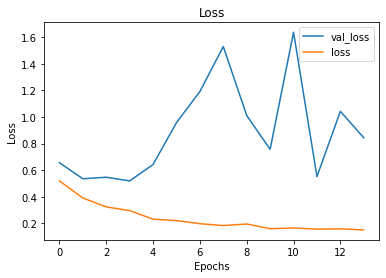

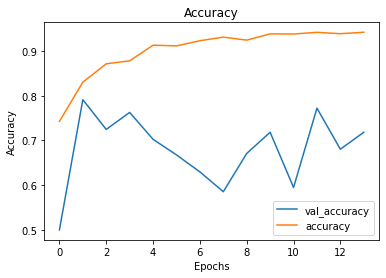

In [142]:
visualize_training_results(history_4)

In [143]:
model_results(model_4)

11/11 [==============================] - 0s 7ms/step - loss: 0.2944 - accuracy: 0.8735
training loss:0.19, training accuracy:0.93
validation loss:0.52, validation accuracy:0.76
testing loss:0.29, testing accuracy:0.87


In [58]:
results_train = saved_model.evaluate(train_images_final,train_labels)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(val_images_final,val_labels)
print(f'Validation Loss: {results_test[0]:.3} \nValidation Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 2s 8ms/step - loss: 0.3434 - accuracy: 0.8355
Training Loss: 0.343 
Training Accuracy: 0.836
----------
10/10 [==============================] - 0s 7ms/step - loss: 0.4600 - accuracy: 0.8133
Validation Loss: 0.46 
Validation Accuracy: 0.813


Although we lost accuracy on our training set, using early stopping caused our model to be less overfit, and achieve the strongest validation accuracy yet. This model also only trained for 14 epochs, saving us time.

## Model 5: L2 Regularization

L2 Regularization is the most common type of regularization, which penalizes weight matrices for being too large, forcing the network to be simplified.

In [59]:
from keras import regularizers

np.random.seed(123)

# initialize model
model_5 = Sequential()
# add Dense layers to the network
model_5.add(layers.Dense(10, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(.005)))
model_5.add(layers.Dense(7, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_5.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.l2(.005)))
model_5.add(layers.Dense(1, activation='sigmoid'))

In [60]:
model_5.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_5 = model_5.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 4s 20ms/step - loss: 0.7708 - accuracy: 0.7406 - val_loss: 1.0021 - val_accuracy: 0.5380
Epoch 2/30
163/163 [==============================] - 3s 16ms/step - loss: 0.5121 - accuracy: 0.8630 - val_loss: 0.8416 - val_accuracy: 0.6867
Epoch 3/30
163/163 [==============================] - 3s 17ms/step - loss: 0.4646 - accuracy: 0.9040 - val_loss: 1.1716 - val_accuracy: 0.6108
Epoch 4/30
163/163 [==============================] - 3s 17ms/step - loss: 0.4407 - accuracy: 0.9046 - val_loss: 1.2930 - val_accuracy: 0.6013
Epoch 5/30
163/163 [==============================] - 3s 17ms/step - loss: 0.4285 - accuracy: 0.9101 - val_loss: 1.2304 - val_accuracy: 0.6297
Epoch 6/30
163/163 [==============================] - 3s 18ms/step - loss: 0.3945 - accuracy: 0.9284 - val_loss: 1.5453 - val_accuracy: 0.6076
Epoch 7/30
163/163 [==============================] - 3s 16ms/step - loss: 0.3714 - accuracy: 0.9371 - val_loss: 0.9325 - val_accuracy: 0.7089

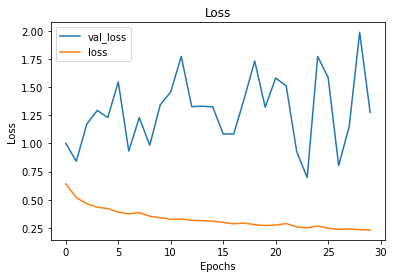

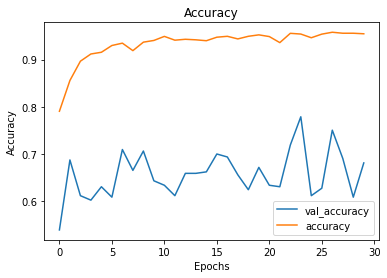

In [61]:
visualize_training_results(history_5)

In [144]:
model_results(model_5)

11/11 [==============================] - 0s 12ms/step - loss: 0.7040 - accuracy: 0.8302
training loss:0.21, training accuracy:0.97
validation loss:1.27, validation accuracy:0.68
testing loss:0.7, testing accuracy:0.83


In [62]:
model_5.evaluate(train_images_final, train_labels)

163/163 [==============================] - 2s 9ms/step - loss: 0.2124 - accuracy: 0.9659


[0.21243232488632202, 0.9658742547035217]

In [63]:
model_5.evaluate(val_images_final, val_labels)

10/10 [==============================] - 0s 6ms/step - loss: 1.2743 - accuracy: 0.6804


[1.27432382106781, 0.6803797483444214]

Using L2 regularization did not help our model much, as our loss increased greatly on validation and testing sets.

## Model 6: L1 Regularization

In [64]:
np.random.seed(123)

model_6 = Sequential()
# add Dense layers to the network
model_6.add(layers.Dense(10, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l1(.005)))
model_6.add(layers.Dense(7, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model_6.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model_6.add(layers.Dense(1, activation='sigmoid'))

In [65]:
model_6.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_6 = model_6.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 5s 24ms/step - loss: 12.0617 - accuracy: 0.7415 - val_loss: 2.6116 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 3s 18ms/step - loss: 1.6103 - accuracy: 0.7394 - val_loss: 1.0101 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 3s 18ms/step - loss: 0.8722 - accuracy: 0.7421 - val_loss: 1.0161 - val_accuracy: 0.5000
Epoch 4/30
163/163 [==============================] - 3s 17ms/step - loss: 0.8237 - accuracy: 0.7513 - val_loss: 1.0343 - val_accuracy: 0.5000
Epoch 5/30
163/163 [==============================] - 3s 18ms/step - loss: 0.8310 - accuracy: 0.7305 - val_loss: 1.0570 - val_accuracy: 0.5000
Epoch 6/30
163/163 [==============================] - 3s 19ms/step - loss: 0.8230 - accuracy: 0.7373 - val_loss: 1.0451 - val_accuracy: 0.5000
Epoch 7/30
163/163 [==============================] - 3s 18ms/step - loss: 0.8148 - accuracy: 0.7472 - val_loss: 1.0255 - val_accuracy: 0.500

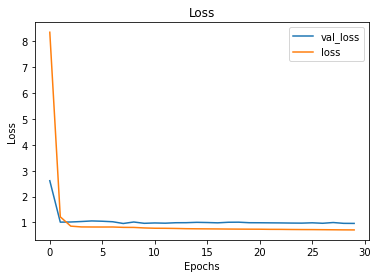

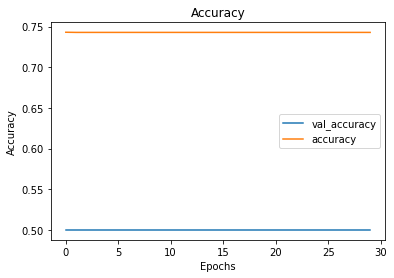

In [66]:
visualize_training_results(history_6)

In [145]:
model_results(model_6)

11/11 [==============================] - 0s 6ms/step - loss: 0.7084 - accuracy: 0.7407
training loss:0.71, training accuracy:0.74
validation loss:0.96, validation accuracy:0.5
testing loss:0.71, testing accuracy:0.74


We achieved even worse results using L1 regularization.

## Model 7: Dropout

The dropout technique of regularization works by dropping/ignoring (setting weights equal to zero) a random subset of nodes in a layer during training. Dropout can be applied to both input layers and hidden layers. It requires a rate argument that specifies the percentage of units to drop.

In [69]:
np.random.seed(123)

# initialize model
model_7 = Sequential()

# add Dense layers to the network
model_7.add(layers.Dense(10, activation='relu', input_shape=(input_shape,)))
# add dropout to first hidden layer
model_7.add(layers.Dropout(0.3))

model_7.add(layers.Dense(7, activation='relu'))
# add dropout to second hidden layer
model_7.add(layers.Dropout(0.3))

model_7.add(layers.Dense(5, activation='relu'))

model_7.add(layers.Dense(1, activation='sigmoid'))

In [70]:
model_7.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)
#fit model
history_7 = model_7.fit(train_images_final,
                    train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images_final, val_labels))

Epoch 1/30
163/163 [==============================] - 3s 14ms/step - loss: 0.6119 - accuracy: 0.7320 - val_loss: 0.7363 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 2s 12ms/step - loss: 0.4717 - accuracy: 0.7342 - val_loss: 0.6349 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 2s 12ms/step - loss: 0.4045 - accuracy: 0.7388 - val_loss: 0.5518 - val_accuracy: 0.5000
Epoch 4/30
163/163 [==============================] - 2s 12ms/step - loss: 0.3668 - accuracy: 0.7460 - val_loss: 0.6117 - val_accuracy: 0.5000
Epoch 5/30
163/163 [==============================] - 2s 12ms/step - loss: 0.4005 - accuracy: 0.7555 - val_loss: 0.6176 - val_accuracy: 0.6994
Epoch 6/30
163/163 [==============================] - 2s 12ms/step - loss: 0.3490 - accuracy: 0.8407 - val_loss: 0.9542 - val_accuracy: 0.6361
Epoch 7/30
163/163 [==============================] - 2s 12ms/step - loss: 0.3441 - accuracy: 0.8467 - val_loss: 0.9884 - val_accuracy: 0.6266

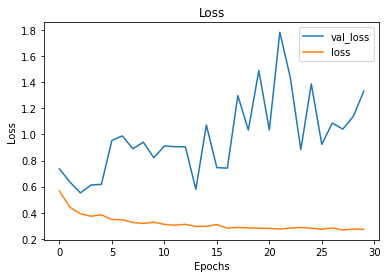

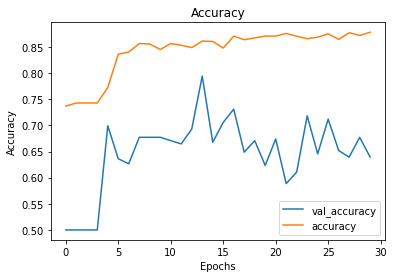

In [71]:
visualize_training_results(history_7)

In [146]:
model_results(model_7)

11/11 [==============================] - 0s 6ms/step - loss: 0.6334 - accuracy: 0.7994
training loss:0.17, training accuracy:0.95
validation loss:1.33, validation accuracy:0.64
testing loss:0.63, testing accuracy:0.8


In [72]:
model_7.evaluate(train_images_final, train_labels)

163/163 [==============================] - 1s 7ms/step - loss: 0.1749 - accuracy: 0.9525


[0.1748572736978531, 0.9524539709091187]

In [73]:
model_7.evaluate(val_images_final, val_labels)

10/10 [==============================] - 0s 5ms/step - loss: 1.3316 - accuracy: 0.6392


[1.3315750360488892, 0.6392405033111572]

Our accuracy scores have not improved much over previous scores, and our validation set is performing worse. 

The only acceptable results we achieved through regularization was using early stopping, which showed a slight decrease in training accuracy but an increase in validation accuracy and decrease in overfitting. We will declare model_4 our best model using an MLP. Next, we will begin using CNNs and see if we can achieve stronger results.

## Model 8: CNN

Convolutional neural networks (CNNs) are a different type of neural network that are very useful in image processing, as densely connected networks can grow very large with high resolution images. CNNs perform a convolution operation, which can learn local patterns in different regions of an image and then apply those patterns with other regions. As the layers in a CNN increase, the patterns learned become increasingly larger based on features of the previous layers. Below is some of the layer architecture included in CNNs:

**Conv2D**: a convolutional layer that uses a "filter" on an image to detect a certain feature about that image. The numbers following the Conv2D specifies how big the region is that is being applied to the image, so Conv(3,3) would use a 3x3 filter and apply it continuously over the image.

**Padding**: Adds a layer of pixels around our image so that information around the edges is not lost when applying the filter over the original image. This can be configured by adding a padding argument to our convolutional layer; a value of "same" means the output of the layer will have the same shape as the input layer, preventing information from being lost.

**MaxPooling2D**: a pooling layer, this layer downsamples the previous convolutional layers in order to reduce our training time. The idea of max pooling is that by taking the max values of all convolutions from a larger area of the original image will tell us whether or not a feature is present in that region, without having to keep all of the information we found during convolution. The 2 hyperparameters are filter size and stride size.

We are also going to try using data augmentation with our CNN models. Data augmentation can be done using the ImageDataGenerator, and it creates different images by randomly adjusting the original images in our dataset and trains the model on these augmented images. Applying data augmentation can improve the performance of our model, because the model will see "new" changed images in every epoch.

In [153]:
batch_size=32
train_steps = train_len/batch_size
train_steps

163.0

In [156]:
# include data augmentation with our CNN models.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.3, 
                                   zoom_range=0.2, 
                                   horizontal_flip=False)

In [157]:
# new train generator with batch size of 32
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(target_size),
                                                    batch_size=32,
                                                    class_mode=class_mode)

Found 5216 images belonging to 2 classes.


In [158]:
# don't perform augmentation on your test and validation set
test_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(test_dir,
                                                         target_size=(target_size),
                                                         batch_size=32,
                                                         class_mode=class_mode)

val_generator = ImageDataGenerator(rescale=rescale).flow_from_directory(val_dir,
                                                         target_size=(target_size),
                                                         batch_size=32,
                                                         class_mode=class_mode)

Found 324 images belonging to 2 classes.
Found 316 images belonging to 2 classes.


In [159]:
np.random.seed(123)

model_8 = Sequential()
model_8.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))

model_8.add(layers.Flatten())
model_8.add(layers.Dense(64, activation='relu'))
model_8.add(layers.Dense(1, activation='sigmoid'))

In [160]:
model_8.compile(optimizer=opt,
                loss=loss,
                metrics=metrics)

model_8.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)           

In the above summary of our CNN model, we see that our data remains in multi-dimensional matrices until it reachs the flatten step, where the data is then ready to entire the dense layers of the network. This model has over 1 million parameters, but the number of parameters in the convolutional steps remains relatively small. This speaks to how efficient the CNN is in processing image data. The shape increases as the convolutional layers increase because...

In [161]:
history_8 = model_8.fit(train_generator, 
                    steps_per_epoch=30, 
                    epochs=30, 
                    validation_data=val_generator)

Epoch 1/30
30/30 [==============================] - 41s 1s/step - loss: 0.6105 - accuracy: 0.6995 - val_loss: 0.8138 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 45s 2s/step - loss: 0.5587 - accuracy: 0.7517 - val_loss: 0.7183 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 47s 2s/step - loss: 0.5744 - accuracy: 0.7373 - val_loss: 0.8897 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 42s 1s/step - loss: 0.5501 - accuracy: 0.7406 - val_loss: 0.7657 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 43s 1s/step - loss: 0.5308 - accuracy: 0.7397 - val_loss: 0.6704 - val_accuracy: 0.5032
Epoch 6/30
30/30 [==============================] - 44s 1s/step - loss: 0.5132 - accuracy: 0.7502 - val_loss: 0.5836 - val_accuracy: 0.6835
Epoch 7/30
30/30 [==============================] - 50s 2s/step - loss: 0.4926 - accuracy: 0.7799 - val_loss: 0.9729 - val_accuracy: 0.5000
Epoch 8/30
30/30 [==

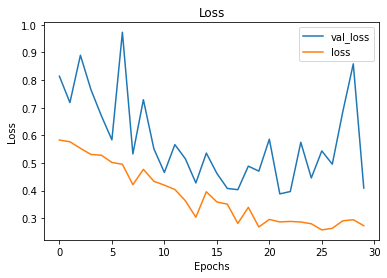

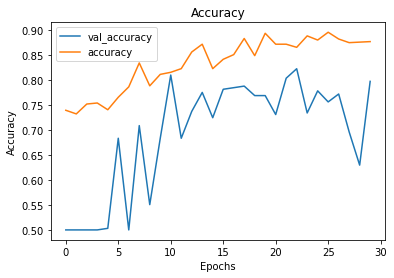

In [162]:
visualize_training_results(history_8)

In [163]:
#write new function that provides results of CNN models
def cnn_model_results(model):
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"training loss:{round(train_loss,2)}, training accuracy:{round(train_acc,2)}")
    
    print(f"validation loss:{round(val_loss,2)}, validation accuracy:{round(val_acc,2)}")
    
    print(f"testing loss:{round(test_loss,2)}, testing accuracy:{round(test_acc,2)}")

In [164]:
cnn_model_results(model_8)

11/11 [==============================] - 7s 586ms/step - loss: 0.2649 - accuracy: 0.9043
training loss:0.28, training accuracy:0.89
validation loss:0.41, validation accuracy:0.8
testing loss:0.26, testing accuracy:0.9


In [81]:
model_8.evaluate(train_images, train_labels)

163/163 [==============================] - 33s 199ms/step - loss: 0.1973 - accuracy: 0.9172


[0.19729921221733093, 0.9171779155731201]

In [82]:
model_8.evaluate(val_images, val_labels)

10/10 [==============================] - 2s 198ms/step - loss: 0.6805 - accuracy: 0.7089


[0.6804739832878113, 0.7088607549667358]

In [83]:
model_8.evaluate(test_images, test_labels)

11/11 [==============================] - 2s 175ms/step - loss: 0.2624 - accuracy: 0.8889


[0.2624272108078003, 0.8888888955116272]

## CNN wih Additional Layers and Units

The training results of our model are much closer to the testing results than any of the models we have run so far, suggesting this model is much less overfit. Let's see if adding layers and units to our model can help improve the performance at all.

In [165]:
np.random.seed(123)

model_9 = Sequential()
model_9.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
model_9.add(layers.MaxPooling2D((2, 2)))

# increase layer from 32 to 64 units
model_9.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_9.add(layers.MaxPooling2D((2, 2)))

model_9.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_9.add(layers.MaxPooling2D((2, 2)))

# add a new convolutional layer with 128 units and 3x3 filter
model_9.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_9.add(layers.MaxPooling2D((2, 2)))

model_9.add(layers.Flatten())
model_9.add(layers.Dense(64, activation='relu'))
model_9.add(layers.Dense(1, activation='sigmoid'))

model_9.compile(optimizer=opt,
                loss=loss,
                metrics=metrics)

In [166]:
history_9 = model_9.fit(train_generator, 
                    steps_per_epoch=30, 
                    epochs=30,
                    validation_data=val_generator)

Epoch 1/30
30/30 [==============================] - 47s 2s/step - loss: 0.6385 - accuracy: 0.6744 - val_loss: 0.8212 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 44s 1s/step - loss: 0.6022 - accuracy: 0.7099 - val_loss: 0.8561 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 43s 1s/step - loss: 0.5938 - accuracy: 0.7224 - val_loss: 0.8343 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 47s 2s/step - loss: 0.5641 - accuracy: 0.7422 - val_loss: 0.7753 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 47s 2s/step - loss: 0.5588 - accuracy: 0.7433 - val_loss: 0.8198 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 47s 2s/step - loss: 0.5592 - accuracy: 0.7355 - val_loss: 0.8539 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 46s 2s/step - loss: 0.5176 - accuracy: 0.7786 - val_loss: 0.7219 - val_accuracy: 0.5000
Epoch 8/30
30/30 [==

In [167]:
cnn_model_results(model_9)

11/11 [==============================] - 7s 576ms/step - loss: 0.2452 - accuracy: 0.9043
training loss:0.24, training accuracy:0.9
validation loss:0.5, validation accuracy:0.78
testing loss:0.25, testing accuracy:0.9


Slightly better results. There does not appear to be any overfitting in the model, as our accuracy results are nearly the same for training and testing, with our testing loss only slightly higher. Let's see if adding padding to our convolutional layers if our results change at all.

## CNN with Padding

In [168]:
np.random.seed(123)

model_10 = Sequential()

# add padding argument to each convolutional layer
model_10.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(150 ,150,  3)))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Flatten())
model_10.add(layers.Dense(64, activation='relu'))
model_10.add(layers.Dense(1, activation='sigmoid'))

model_10.compile(optimizer=opt,
                loss=loss,
                metrics=metrics)

In [169]:
history_10 = model_10.fit(train_generator, 
                    steps_per_epoch=30, 
                    epochs=30,
                    validation_data=val_generator)

Epoch 1/30
30/30 [==============================] - 51s 2s/step - loss: 0.6300 - accuracy: 0.7325 - val_loss: 0.7717 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 51s 2s/step - loss: 0.5935 - accuracy: 0.7229 - val_loss: 0.8336 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 54s 2s/step - loss: 0.5835 - accuracy: 0.7295 - val_loss: 0.7841 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 54s 2s/step - loss: 0.5511 - accuracy: 0.7568 - val_loss: 0.8774 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 59s 2s/step - loss: 0.5155 - accuracy: 0.7780 - val_loss: 0.7762 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 54s 2s/step - loss: 0.5375 - accuracy: 0.7521 - val_loss: 0.7249 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 56s 2s/step - loss: 0.5446 - accuracy: 0.7340 - val_loss: 0.8599 - val_accuracy: 0.5000
Epoch 8/30
30/30 [==

In [170]:
cnn_model_results(model_10)

11/11 [==============================] - 7s 624ms/step - loss: 0.2098 - accuracy: 0.9167
training loss:0.23, training accuracy:0.91
validation loss:0.52, validation accuracy:0.75
testing loss:0.21, testing accuracy:0.92


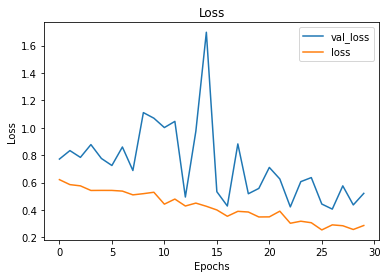

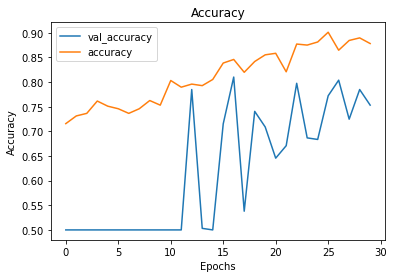

In [171]:
visualize_training_results(history_10)

We were able to get even better results by using padding. Since these were our strongest results with the least amount of overfitting, we are going to proceed with this model. To make sure we are getting the strongest results possible, we are going to train this model with more epochs and implement early stopping to prevent the model from overfitting.

In [172]:
early_stopping = [EarlyStopping(monitor='val_loss',patience=10),
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [176]:
history_final = model_10.fit(train_generator, 
                    steps_per_epoch=50, 
                    epochs=50,
                    callbacks=early_stopping,
                    validation_data=val_generator,
                            validation_steps=10)

Epoch 1/50
50/50 [==============================] - 99s 2s/step - loss: 0.1426 - accuracy: 0.9438 - val_loss: 0.8605 - val_accuracy: 0.7500
Epoch 2/50
50/50 [==============================] - 123s 2s/step - loss: 0.1323 - accuracy: 0.9488 - val_loss: 0.4749 - val_accuracy: 0.8386
Epoch 3/50
50/50 [==============================] - 160s 3s/step - loss: 0.1431 - accuracy: 0.9463 - val_loss: 0.4471 - val_accuracy: 0.8418
Epoch 4/50
50/50 [==============================] - 129s 3s/step - loss: 0.1402 - accuracy: 0.9481 - val_loss: 0.6517 - val_accuracy: 0.7848
Epoch 5/50
50/50 [==============================] - 158s 3s/step - loss: 0.1247 - accuracy: 0.9544 - val_loss: 0.7016 - val_accuracy: 0.7753
Epoch 6/50
50/50 [==============================] - 103s 2s/step - loss: 0.1347 - accuracy: 0.9463 - val_loss: 0.4318 - val_accuracy: 0.8386
Epoch 7/50
50/50 [==============================] - 70s 1s/step - loss: 0.1408 - accuracy: 0.9488 - val_loss: 0.5449 - val_accuracy: 0.8259
Epoch 8/50
50/5

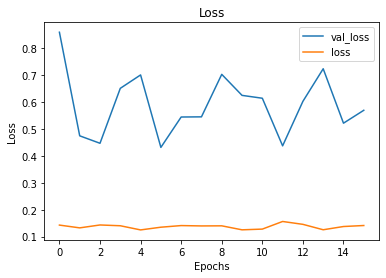

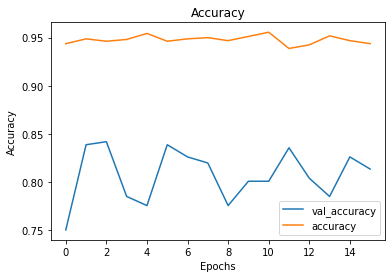

In [177]:
visualize_training_results(history_final)

In [178]:
cnn_model_results(model_10)

11/11 [==============================] - 6s 555ms/step - loss: 0.0958 - accuracy: 0.9568
training loss:0.12, training accuracy:0.96
validation loss:0.57, validation accuracy:0.81
testing loss:0.1, testing accuracy:0.96


Implementing longer training times improved our model even further. We will proceed our analysis with this as our final model.

In [97]:
# model_11 = Sequential()
# model_11.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Flatten())
# model_11.add(layers.Dense(512, activation='relu'))
# #model_11.add(layers.Dropout(0.3))
# model_11.add(layers.Dense(1, activation='sigmoid'))

## Model 9: CNN with Early Stopping

In [84]:
early_stopping = [EarlyStopping(monitor='val_loss',patience=10),
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [85]:
history_9 = model_8.fit(train_generator, 
                    steps_per_epoch=30, 
                    epochs=30,
                    callbacks=early_stopping,
                    validation_data=val_generator)

Epoch 1/30
30/30 [==============================] - 42s 1s/step - loss: 0.3008 - accuracy: 0.8750 - val_loss: 0.5171 - val_accuracy: 0.7722
Epoch 2/30
30/30 [==============================] - 41s 1s/step - loss: 0.2621 - accuracy: 0.8885 - val_loss: 0.9528 - val_accuracy: 0.6329
Epoch 3/30
30/30 [==============================] - 41s 1s/step - loss: 0.2671 - accuracy: 0.8875 - val_loss: 0.5339 - val_accuracy: 0.7753
Epoch 4/30
30/30 [==============================] - 40s 1s/step - loss: 0.2635 - accuracy: 0.8750 - val_loss: 0.7584 - val_accuracy: 0.6804
Epoch 5/30
30/30 [==============================] - 40s 1s/step - loss: 0.2489 - accuracy: 0.8927 - val_loss: 0.4916 - val_accuracy: 0.7785
Epoch 6/30
30/30 [==============================] - 42s 1s/step - loss: 0.2745 - accuracy: 0.8875 - val_loss: 0.5971 - val_accuracy: 0.7500
Epoch 7/30
30/30 [==============================] - 40s 1s/step - loss: 0.2549 - accuracy: 0.8875 - val_loss: 0.6618 - val_accuracy: 0.7247
Epoch 8/30
30/30 [==

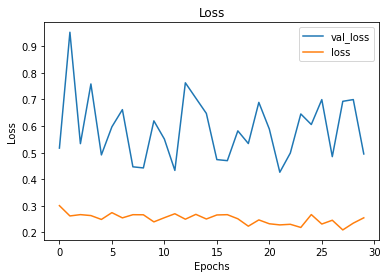

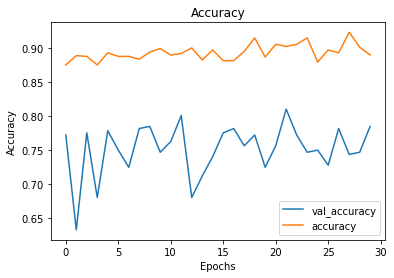

In [86]:
visualize_training_results(history_9)

In [87]:
model_9 = load_model('best_model.h5')

In [88]:
model_9.evaluate(train_generator)

163/163 [==============================] - 119s 731ms/step - loss: 0.2567 - accuracy: 0.8907


[0.2566855549812317, 0.8907208442687988]

In [89]:
model_9.evaluate(val_generator)

10/10 [==============================] - 6s 529ms/step - loss: 0.4264 - accuracy: 0.8101


[0.4264231324195862, 0.8101266026496887]

In [90]:
test_loss, test_acc = model_9.evaluate_generator(test_generator)
print('test accuracy:', round(test_acc*100, 2))
print('test loss:' , round(test_loss, 2))

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test accuracy: 91.36
test loss: 0.22


We were able to get much better validation set results, however, our test results still have room for improvement. Let's run a model that also includes dropout to see if we can get test results closer to our training results.

## Model 10: CNN with Dropout

In [91]:
np.random.seed(123)
model_10 = Sequential()
model_10.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_10.add(layers.MaxPooling2D((2, 2)))

model_10.add(layers.Flatten())
model_10.add(layers.Dense(64, activation='relu'))
model_10.add(layers.Dropout(0.3))
model_10.add(layers.Dense(1, activation='sigmoid'))

model_10.compile(optimizer=opt,
                 loss=loss,
                 metrics=metrics)

In [92]:
history_10 = model_10.fit(train_generator, 
                    steps_per_epoch=30, 
                    epochs=30,
                    callbacks=early_stopping,
                    validation_data=val_generator)

Epoch 1/30
30/30 [==============================] - 40s 1s/step - loss: 0.6302 - accuracy: 0.6853 - val_loss: 0.8033 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 38s 1s/step - loss: 0.5721 - accuracy: 0.7458 - val_loss: 0.8538 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 38s 1s/step - loss: 0.5715 - accuracy: 0.7411 - val_loss: 0.8219 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 38s 1s/step - loss: 0.5299 - accuracy: 0.7715 - val_loss: 0.7510 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 39s 1s/step - loss: 0.5584 - accuracy: 0.7280 - val_loss: 0.9179 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 39s 1s/step - loss: 0.5628 - accuracy: 0.7146 - val_loss: 0.6367 - val_accuracy: 0.5475
Epoch 7/30
30/30 [==============================] - 38s 1s/step - loss: 0.5045 - accuracy: 0.7629 - val_loss: 0.5822 - val_accuracy: 0.7437
Epoch 8/30
30/30 [==

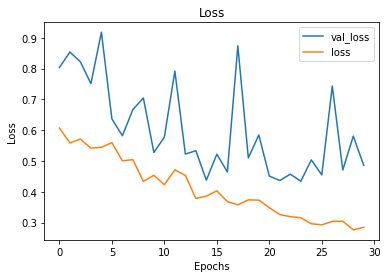

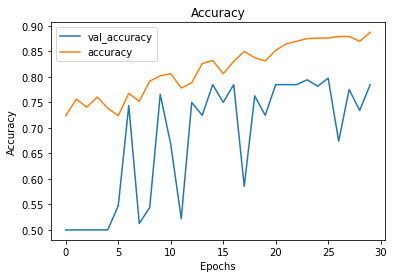

In [93]:
visualize_training_results(history_10)

In [94]:
model_10.evaluate(train_images, train_labels)

163/163 [==============================] - 33s 198ms/step - loss: 0.2219 - accuracy: 0.9164


[0.22192025184631348, 0.9164110422134399]

In [95]:
model_10.evaluate(val_images, val_labels)

10/10 [==============================] - 2s 182ms/step - loss: 0.4857 - accuracy: 0.7848


[0.4856822192668915, 0.7848101258277893]

In [96]:
model_10.evaluate(test_images, test_labels)

11/11 [==============================] - 2s 171ms/step - loss: 0.2425 - accuracy: 0.9074


[0.24254697561264038, 0.9074074029922485]

In [88]:
model_10.evaluate(train_generator)

163/163 [==============================] - 119s 731ms/step - loss: 0.2567 - accuracy: 0.8907


[0.2566855549812317, 0.8907208442687988]

In [89]:
model_10.evaluate(val_generator)

10/10 [==============================] - 6s 529ms/step - loss: 0.4264 - accuracy: 0.8101


[0.4264231324195862, 0.8101266026496887]

In [90]:
test_loss, test_acc = model_10.evaluate_generator(test_generator)
print('test accuracy:', round(test_acc*100, 2))
print('test loss:' , round(test_loss, 2))

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test accuracy: 91.36
test loss: 0.22


## Model 11: Use of Kernel Weight Initializer

THe purpose of initializing weights is to prevent layer activation outputs from exploding or vanishing.

In [104]:
from tensorflow.keras import initializers

In [105]:
# generates initial weight tensors with a normal distribution with mean of 0 and standard deviation of 1.
initializer = initializers.RandomNormal(mean=0., stddev=1.)

model_11 = Sequential()
model_11.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
model_11.add(layers.MaxPooling2D((2, 2)))

model_11.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_11.add(layers.MaxPooling2D((2, 2)))

model_11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_11.add(layers.MaxPooling2D((2, 2)))

model_11.add(layers.Flatten())
model_11.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model_11.add(layers.Dropout(0.3))
model_11.add(layers.Dense(1, activation='sigmoid'))

model_11.compile(optimizer=opt,
                 loss=loss,
                 metrics=metrics)

In [106]:
history_11 = model_11.fit(train_generator, 
                    steps_per_epoch=30, 
                    epochs=30,
                    callbacks=early_stopping,
                    validation_data=val_generator)

Epoch 1/30
30/30 [==============================] - 45s 1s/step - loss: 6.9657 - accuracy: 0.5739 - val_loss: 0.9288 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 54s 2s/step - loss: 0.6030 - accuracy: 0.7271 - val_loss: 0.8129 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 58s 2s/step - loss: 0.5276 - accuracy: 0.7795 - val_loss: 0.8381 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 58s 2s/step - loss: 0.6245 - accuracy: 0.6814 - val_loss: 0.7875 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 59s 2s/step - loss: 0.5689 - accuracy: 0.7376 - val_loss: 0.8148 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 57s 2s/step - loss: 0.5776 - accuracy: 0.7488 - val_loss: 0.7551 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 59s 2s/step - loss: 0.5756 - accuracy: 0.7253 - val_loss: 0.6340 - val_accuracy: 0.5918
Epoch 8/30
30/30 [==

In [107]:
model_11.evaluate(train_generator)

163/163 [==============================] - 223s 1s/step - loss: 0.2475 - accuracy: 0.8999


[0.24752426147460938, 0.8999233245849609]

In [108]:
model_11.evaluate(val_generator)

10/10 [==============================] - 10s 939ms/step - loss: 0.5817 - accuracy: 0.7342


[0.5817483067512512, 0.7341772317886353]

In [109]:
test_loss, test_acc = model_11.evaluate_generator(test_generator)
print('test accuracy:', round(test_acc*100, 2))
print('test loss:' , round(test_loss, 2))

test accuracy: 90.74
test loss: 0.23


## Model 12: CNN Including Batch Normalization

In [110]:
from keras.layers import BatchNormalization

model_12 = Sequential()
model_12.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
model_12.add(BatchNormalization())
model_12.add(layers.MaxPooling2D((2, 2)))
model_12.add(BatchNormalization())
model_12.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_12.add(BatchNormalization())
model_12.add(layers.MaxPooling2D((2, 2)))
model_12.add(BatchNormalization())
model_12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_12.add(BatchNormalization())
model_12.add(layers.MaxPooling2D((2, 2)))
model_12.add(BatchNormalization())

model_12.add(layers.Flatten())
model_12.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model_12.add(BatchNormalization())
model_12.add(layers.Dropout(0.3))
model_12.add(layers.Dense(1, activation='sigmoid'))

model_12.compile(optimizer=opt,
                 loss=loss,
                 metrics=metrics)

In [111]:
history_12 = model_12.fit(train_generator, 
                    steps_per_epoch=30, 
                    epochs=30,
                    callbacks=early_stopping,
                    validation_data=val_generator)

Epoch 1/30
30/30 [==============================] - 95s 3s/step - loss: 0.7487 - accuracy: 0.6386 - val_loss: 0.6797 - val_accuracy: 0.5728
Epoch 2/30
30/30 [==============================] - 86s 3s/step - loss: 0.5453 - accuracy: 0.7468 - val_loss: 0.7924 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - 70s 2s/step - loss: 0.5121 - accuracy: 0.7576 - val_loss: 0.9876 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - 60s 2s/step - loss: 0.4765 - accuracy: 0.8032 - val_loss: 1.1192 - val_accuracy: 0.5000
Epoch 5/30
30/30 [==============================] - 69s 2s/step - loss: 0.3978 - accuracy: 0.8236 - val_loss: 1.2836 - val_accuracy: 0.5000
Epoch 6/30
30/30 [==============================] - 76s 3s/step - loss: 0.3675 - accuracy: 0.8544 - val_loss: 1.6216 - val_accuracy: 0.5000
Epoch 7/30
30/30 [==============================] - 85s 3s/step - loss: 0.3396 - accuracy: 0.8562 - val_loss: 1.5568 - val_accuracy: 0.5000
Epoch 8/30
30/30 [==

In [107]:
model_11.evaluate(train_generator)

163/163 [==============================] - 223s 1s/step - loss: 0.2475 - accuracy: 0.8999


[0.24752426147460938, 0.8999233245849609]

In [108]:
model_11.evaluate(val_generator)

10/10 [==============================] - 10s 939ms/step - loss: 0.5817 - accuracy: 0.7342


[0.5817483067512512, 0.7341772317886353]

In [109]:
test_loss, test_acc = model_11.evaluate_generator(test_generator)
print('test accuracy:', round(test_acc*100, 2))
print('test loss:' , round(test_loss, 2))

test accuracy: 90.74
test loss: 0.23


In [ ]:
model_11.save('final_x_ray_model.h5')

## Model 11: CNN with Additional Layers

In [97]:
# model_11 = Sequential()
# model_11.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model_11.add(layers.MaxPooling2D((2, 2)))
# model_11.add(layers.Flatten())
# model_11.add(layers.Dense(512, activation='relu'))
# #model_11.add(layers.Dropout(0.3))
# model_11.add(layers.Dense(1, activation='sigmoid'))

In [98]:
# model_11.compile(loss='binary_crossentropy',
#               optimizer=SGD(lr=0.001),
#               metrics=['accuracy'])

In [99]:
# history_11 = model_11.fit(train_generator, 
#                     steps_per_epoch=162, 
#                     epochs=30,
#                     callbacks=early_stopping,
#                     validation_data=val_generator)

In [100]:
# visualize_training_results(history_11)

In [101]:
# model_11.evaluate(train_images, train_labels)

In [102]:
# model_11.evaluate(val_images, val_labels)

In [103]:
# model_11.evaluate(test_images, test_labels)

Using a model with additional layers and additional (units?) did not improve our testing accuracy, which is to be expected; our more complicated model has overfit on the training data. Before choosing our final model, let's quickly take a look at different optimizers and see what works best for our model.

# Model Evaluation

## Final Model Evaluation Metrics

In [ ]:
# run model using 50 epochs w/ early stopping
model = load_model()
model.summary()

In [ ]:
visualize_training_results(model)

## Visualizing Intermediate Layers

In [ ]:
img_path = 'images/IM-0115-0001.jpeg'


img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

"Note how the later layers are more abstract representations, and in the case of the final two layers, we see nothing at all. This demonstrates how the representations learned by CNN architectures become increasingly abstract with the depth of the layers. In the case of the blank images displayed, this indicates that the patterns were not present in the current image. In other words, the CNN learned various patterns through training, but these more abstract features such as a rib or a lung were not found in this particular instance."

The way CNNs work is by changing your image through filters in every layer.

## Plot Model

In [ ]:
from keras.util import plot_model, model_to_dot

In [ ]:
plot_model(model)

In [ ]:
model_to_dot(model)

## Confusion Matrix

## Final Conclusions

# Next Steps

## Transfer Learning